# Klasifikasi Ekspresi Wajah dengan Deep Learning

Metode Sebelum data di load:
-  Dataset berasal dari 2 buah dataset sekunder dari kaggle.
-  Dataset digabungkan dan dinormalisasi hingga setara.

### Data Preparation

In [ ]:
!gdown 1Sg0VOIRSRlkvnLAptJScBW8NlcCmO-fD

Kelas disgust tidak dipakai.

In [ ]:
!rm -r dataset/disgust

Rename folder drowsy_gs ke drowsy.

In [ ]:
!mv dataset/drowsy_gs dataset/drowsy

In [ ]:
!pip install split-folders

In [ ]:
!rm -r splitted_dataset

In [ ]:
import splitfolders
input_folder = "dataset"
output = "splitted_dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.9, .1))

Copying files: 42522 files [00:04, 9275.70 files/s] 


Rename foder val menjadi test.

In [ ]:
!mv splitted_dataset/val splitted_dataset/test

### Import Library

In [ ]:
from charset_normalizer import md__mypyc

import numpy as np
import os

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from sklearn.metrics import confusion_matrix

from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight
import urllib.request
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras import layers

In [ ]:
import numpy
print(numpy.__version__)

1.23.5


In [ ]:
import tensorflow
tensorflow.__version__

'2.7.0'

### Data Understanding

Visualisasi data untuk tiap kelas.

Text(0.5, 1.0, 'Surprise')

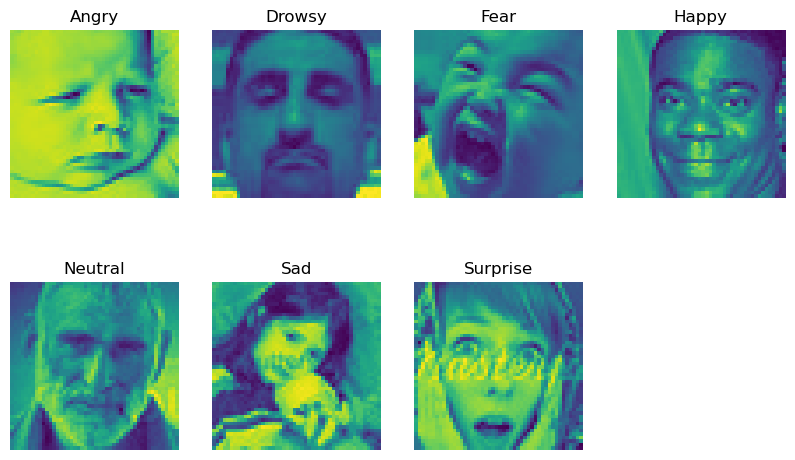

In [ ]:
fig = plt.figure(figsize=(10, 6))

# setting values to rows and column variables
rows = 2
columns = 4

# reading images
Image1 = imread('dataset/angry/PrivateTest_88305.jpg')
# Image2 = imread('dataset/disgust/PrivateTest_30523217.jpg')
Image3 = imread('dataset/drowsy/A0001.jpg')
Image4 = imread('dataset/fear/PrivateTest_134207.jpg')
Image5 = imread('dataset/happy/PrivateTest_95094.jpg')
Image6 = imread('dataset/neutral/PrivateTest_59059.jpg')
Image7 = imread('dataset/sad/PrivateTest_366361.jpg')
Image8 = imread('dataset/surprise/PrivateTest_139065.jpg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Angry")

# Adds a subplot at the 3nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Drowsy")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Fear")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
# showing image
plt.imshow(Image5)
plt.axis('off')
plt.title("Happy")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
# showing image
plt.imshow(Image6)
plt.axis('off')
plt.title("Neutral")

# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
# showing image
plt.imshow(Image7)
plt.axis('off')
plt.title("Sad")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
# showing image
plt.imshow(Image8)
plt.axis('off')
plt.title("Surprise")

### Data Preparation

In [ ]:
!rm -r splitted_dataset/test/.ipynb_checkpoints
!rm -r splitted_dataset/train/.ipynb_checkpoints

Menyiapkan train dan val data dengan augmentasi.

In [ ]:
IMAGE_SIZE = 48
BATCH_SIZE = 128
base_dir = os.path.join('splitted_dataset/train')

#Train-val set
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=10,  # Rotate the image by a certain range (in degrees)
    # width_shift_range=0.1,  # Shift the width of the image by a fraction
    # height_shift_range=0.1,  # Shift the height of the image by a fraction
    zoom_range=0.1,  # Zoom in or out on the image by a fraction
    horizontal_flip=True,  # Flip the image horizontally
    fill_mode='nearest',  # Fill in any newly created pixels during augmentation
    validation_split=0.15)
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode = "grayscale",
    subset='training')
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode = "grayscale",
    subset='validation')

#Test set
X_test = []
y_test = []
labels = ['angry','drowsy', 'fear', 'happy', 'neutral', 'sad', 'surprise']

for i,label in enumerate(labels):
    folder = os.path.join("splitted_dataset/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)

        image = imread(image_path)/255.
        image = resize(image,(48,48,1))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing set
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 32529 images belonging to 7 classes.
Found 5737 images belonging to 7 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 48, 48, 1) (128, 7)
Bentuk array dari dataset validation (validasi) adalah: (128, 48, 48, 1) (128, 7)
Bentuk array dari dataset test (pengujian) adalah: (4256, 48, 48, 1) (4256,)


Menyimpan label

In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'angry': 0, 'drowsy': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# class_weights = class_weight.compute_class_weight(
#                 class_weight = 'balanced',
#                 classes = np.unique(train_generator.classes),
#                 y = train_generator.classes)

class_weights = {0: 1.4,
                1: 1.,
                2: 1.5,
                3: 1.,
                4: 1.2,
                5: 1.4,
                6: 1.}

### Modelling

Membangun arsitektur JST.

In [ ]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
  )
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_297 (Conv2D)         (None, 48, 48, 32)        320       
                                                                 
 conv2d_298 (Conv2D)         (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_300 (Ba  (None, 48, 48, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_299 (Conv2D)         (None, 24, 24, 128)      

In [ ]:
# IMG_SHAPE = (224, 224, 3)
# base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
#                                               include_top=False,
#                                               weights='imagenet')
# base_model.trainable = False
# base_model.summary()

In [ ]:
# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(7, activation='softmax')
# ])

# model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
# model.summary()

In [ ]:
# inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# urllib.request.urlretrieve(
#     inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
# local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
#                               include_top = False,
#                               weights = None)
# pre_trained_model.load_weights(local_weights_file)

# for layer in pre_trained_model.layers:
#     layer.trainable = False

# last_layer =  pre_trained_model.get_layer('mixed5').output

In [ ]:
# x = layers.Flatten()(last_layer)
# x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(7, activation='softmax')(x)

# model = Model(pre_trained_model.input, x)
# model.compile(
#     optimizer = Adam(learning_rate=0.0001),
#     loss='categorical_crossentropy',
#     metrics=['acc']
# )

Membuat Callback untuk early stopping

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('acc')>0.80 and logs.get('val_acc')>0.85):
          self.model.stop_training = True
callbacks = myCallback()

Training

In [ ]:
history = model.fit(train_generator,
                    callbacks=callbacks,
                    epochs=100,
                    validation_data=val_generator,
                    class_weight=class_weights
                   )

Epoch 1/100
255/255 [==============================] - 14s 53ms/step - loss: 9.6839 - acc: 0.2687 - val_loss: 9.6073 - val_acc: 0.1691
Epoch 2/100
255/255 [==============================] - 13s 50ms/step - loss: 8.7467 - acc: 0.3290 - val_loss: 8.7912 - val_acc: 0.1724
Epoch 3/100
255/255 [==============================] - 13s 50ms/step - loss: 7.9308 - acc: 0.3651 - val_loss: 7.1079 - val_acc: 0.4033
Epoch 4/100
255/255 [==============================] - 13s 50ms/step - loss: 7.1427 - acc: 0.4014 - val_loss: 6.3079 - val_acc: 0.4516
Epoch 5/100
255/255 [==============================] - 13s 51ms/step - loss: 6.4149 - acc: 0.4245 - val_loss: 5.5935 - val_acc: 0.4816
Epoch 6/100
255/255 [==============================] - 13s 50ms/step - loss: 5.7422 - acc: 0.4452 - val_loss: 4.9838 - val_acc: 0.4978
Epoch 7/100
255/255 [==============================] - 13s 50ms/step - loss: 5.1120 - acc: 0.4732 - val_loss: 4.3996 - val_acc: 0.5158
Epoch 8/100
255/255 [==============================] - 

Visualisasi hasil training

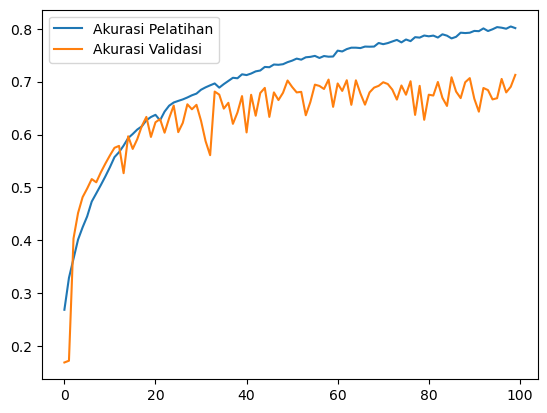

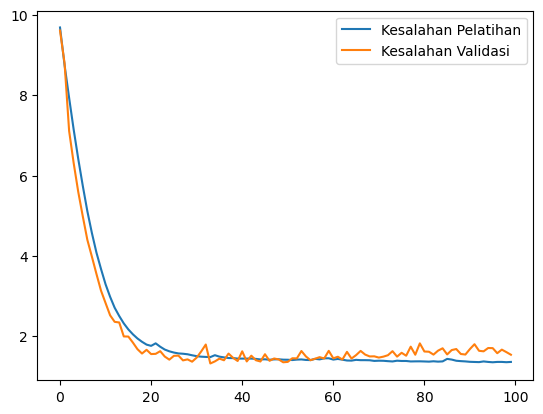

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Akurasi Validasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Kesalahan Validasi")
plt.legend()
plt.show()

Menyimpan model

In [ ]:
model.save("save_model/model.h5")

### Evaluasi

In [ ]:
from keras.utils.np_utils import to_categorical
y_test2=to_categorical(y_test)
X_test3,y_test3=(X_test,y_test2)

In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'acc']
255/255 [==============================] - 11s 42ms/step - loss: 0.9988 - acc: 0.8940
[0.9988354444503784, 0.8939715623855591]
45/45 [==============================] - 2s 42ms/step - loss: 1.5309 - acc: 0.7143
[1.5308821201324463, 0.7143105864524841]
133/133 [==============================] - 0s 2ms/step - loss: 1.4905 - acc: 0.7068
[1.4905457496643066, 0.7067669034004211]


Confusion matrix

In [ ]:
y_true=np.argmax(y_test2,axis=1)
Y_pred=model.predict(X_test)
y_pred=np.argmax(Y_pred,axis=1)

Normalized confusion matrix
[[0.55 0.   0.09 0.05 0.14 0.15 0.02]
 [0.   0.97 0.   0.   0.   0.03 0.  ]
 [0.12 0.   0.44 0.03 0.1  0.23 0.07]
 [0.02 0.   0.03 0.86 0.05 0.03 0.01]
 [0.08 0.   0.05 0.07 0.63 0.16 0.  ]
 [0.1  0.   0.1  0.03 0.19 0.57 0.  ]
 [0.03 0.   0.13 0.03 0.03 0.02 0.75]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Label Prediksi', ylabel='Label Benar'>

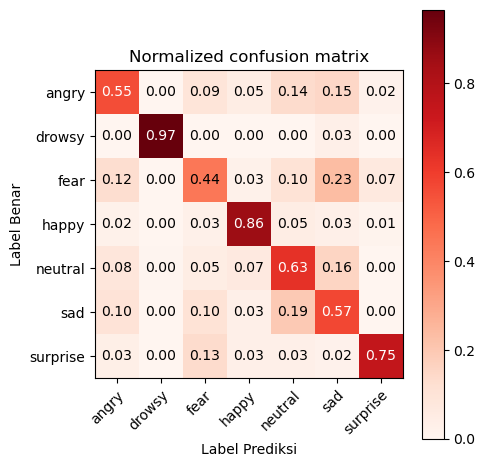

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.51      0.55       991
           1       1.00      0.88      0.93      1437
           2       0.49      0.53      0.51      1025
           3       0.88      0.83      0.86      1798
           4       0.52      0.63      0.57      1240
           5       0.50      0.52      0.51      1216
           6       0.76      0.78      0.77       801

    accuracy                           0.69      8508
   macro avg       0.68      0.67      0.67      8508
weighted avg       0.70      0.69      0.69      8508



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))
print('Precision: %.3f' % precision_score(y_true, y_pred,average='weighted'))
print('Recall: %.3f' % recall_score(y_true, y_pred,average='weighted'))
print('F1 Score: %.3f' % f1_score(y_true, y_pred,average="weighted"))

Accuracy: 0.687
Precision: 0.703
Recall: 0.687
F1 Score: 0.693


### Demo Prediksi Citra

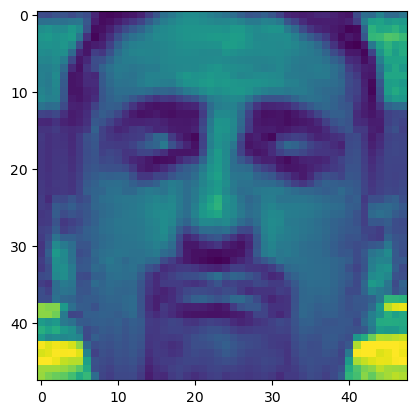

Label yang benar adalah: 1 : drowsy
Nilai yang diprediksi adalah: [0.12 0.45 0.   0.01 0.   0.42 0.  ]
Label yang diprediksi adalah: 1 : drowsy
Prediksi benar


In [ ]:
n = 1000 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")